In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

## 1. Read raw datacube and remove background & fringe

In [2]:
raw_datacube = Read_Raw_SITELLE_datacube("/home/qliu/data/A2465/5PrUCR/2345354p.fits",name="A2465C")
raw_datacube.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2064                                                  
NAXIS3  =                  207                                                  
EXTEND  =                    T                                                  
DATE    = '2019-01-29'         / Creation date                                  
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectrum Cube' / Type of file                             
OBSERVAT= 'CFHT    '           / Observatory name                               
TELESCOP= 'CFHT 3.6m'          / Hawaii Big Island, Mauna Kea                   
INSTRUME= 'SITELLE '        

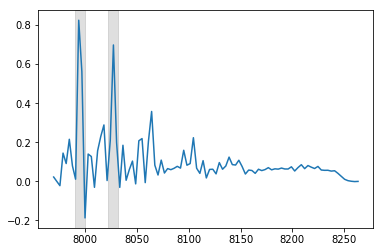

In [23]:
# med_stack = np.median(raw_datacube.raw_cube, axis=0)
# spec_med = [np.median(raw_datacube.raw_cube[k]) for k in range(len(raw_datacube.wavl))]
plt.axvspan(7990,8000,color='gray',alpha=0.25)
plt.axvspan(8022,8032,color='gray',alpha=0.25)
plt.plot(raw_datacube.wavl, spec_med)

In [5]:
raw_datacube.save_mask_edge(save_path = './proc/A2465C/')

Remove 2D background channel by channel.

In [6]:
raw_datacube.remove_background(box_size=128, save_path='./A2465C/fig_iso/bkg/128/', plot=False)

Removing background... Channel: 10
Removing background... Channel: 20
Removing background... Channel: 30
Removing background... Channel: 40
Removing background... Channel: 50
Removing background... Channel: 60
Removing background... Channel: 70
Removing background... Channel: 80
Removing background... Channel: 90


Check stack field. Note the strong fringe pattern.

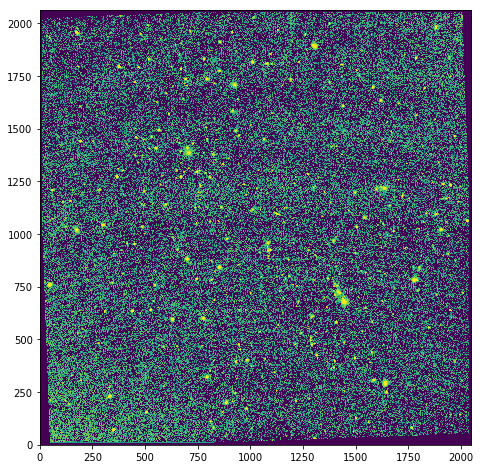

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(raw_datacube.stack_field, norm=norm1, origin="lower", vmin=0, vmax=3)

Looking at some specific channels which suffer most. One choice is to not use / interpolate by nearby channels.

If True, Interpolate from adjacent channels to reduce fringe effects in later on detection.

In [26]:
bad_channel = raw_datacube.interp_bad_channel(wavl_intp_range=[[7990,8000],[8022,8032]], interp=False)

In [45]:
bad_channel = raw_datacube.get_channel([[7986,8006],[8016,8036]])
raw_datacube.remove_fringe(bad_channel, sn_source=5, save_path='./A2465C/fig_iso/bkg/128/', plot=True)

./A2465C/fig_iso/bkg/128/ does not exist. Make a new directory.
Cleaning Channel: 7
Cleaning Channel: 8
Cleaning Channel: 9
Cleaning Channel: 10
Cleaning Channel: 11
Cleaning Channel: 12
Cleaning Channel: 13
Cleaning Channel: 17
Cleaning Channel: 18
Cleaning Channel: 19
Cleaning Channel: 20
Cleaning Channel: 21
Cleaning Channel: 22


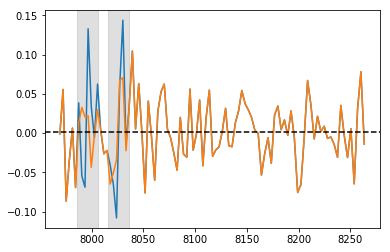

In [39]:
plt.plot(raw_datacube.wavl, raw_datacube.datacube_bkg_sub[:,17,539])
plt.plot(raw_datacube.wavl, raw_datacube.cube_process[:,17,539])
plt.axhline(np.median(raw_datacube.cube_process[:,17,539]),color='k',ls='--')
plt.axvspan(7986,8006,color='gray',alpha=0.25)
plt.axvspan(8016,8036,color='gray',alpha=0.25)

After fringe subtraction:

In [46]:
raw_datacube.save_fits(save_path = './proc/A2465C/', suffix="")

Saving background & fringe subtracted datacube and stacked field...


## 2. Extract source and spectra from datacube 

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube.fits', z0=0.245, name='A2465C', 
                         mask_edge='./proc/A2465C/Raw_stack_A2465C_mask.fits', mode="MMA")

In [3]:
src_map, segm, seg_map = datacube.ISO_source_detection(sn_thre=3, nlevels=64, contrast=0.01, box=(3,3,3),
                                                       closing=True, save=True, save_path = './proc/A2465C/', suffix="")

Use the map of maximum of moving average (MMA) to detect source.
Box shape:  (3, 3, 3)
Detecting and deblending source...


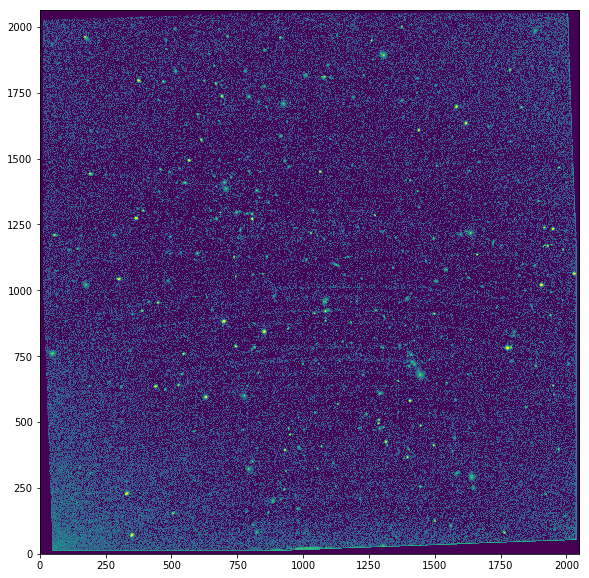

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

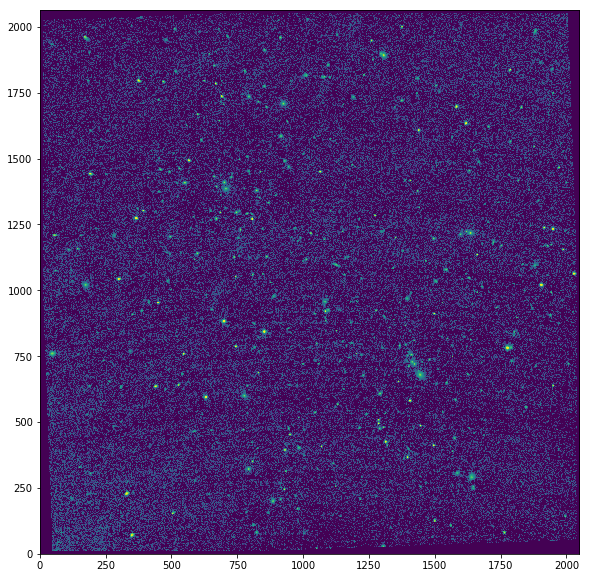

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(datacube.stack_field, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=60)

In [6]:
datacube.ISO_spec_extraction_all(seg_map)

Extract spectra... 400/1239
Extract spectra... 800/1239
Extract spectra... 1200/1239


In [7]:
datacube.fit_continuum_all(model='GP', plot=True, save_path='./A2465C/fig_iso/fit_cont_MMA/')

./A2465C/fig_iso/fit_cont_MMA/ exists. Remove all the content.
Fit continuum with GP. No edge_ratio is given. Use estimate = 0.08
Fit spectra continuum ... 200/1239
Fit spectra continuum ... 400/1239
Fit spectra continuum ... 600/1239
Fit spectra continuum ... 800/1239
Fit spectra continuum ... 1000/1239
Fit spectra continuum ... 1200/1239
Skip spurious detection:  #1 #7 #8 #31 #1101 #1102 #1103 #1104 #1106 #1131 #1133 #1136 #1139 #1143 #1146 #1149 #1150 #1151 #1156 #1158 #1159 #1160 #1161 #1163 #1165 #1166 #1167 #1168 #1170 #1172 #1175 #1177  ... Replaced with random noise.
Continuum Fitting Finished!


In [8]:
datacube.save_spec_fits(save_path='./proc/A2465C', suffix="_all")

## 3. Generate Templates

In [1]:
from pipeline import *
from utils import *

In [2]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA.fits')

In [10]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2, 
                           temp_type="OII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.), 
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8),
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='gauss')

Template: OII_gauss  Total Number: 10
Template: Hb-OIII_gauss  Total Number: 80
Template: Ha-NII_gauss  Total Number: 400


In [11]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2,
                           temp_type="OII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.),
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), 
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box')

Template: OII_box  Total Number: 1
Template: Hb-OIII_box  Total Number: 8
Template: Ha-NII_box  Total Number: 40


In [12]:
for mod in ['gauss','box']:
    for typ in ["Ha-NII", "Hb-OIII", "OII"]:
        datacube.Save_Template(save_path='./proc/template/', temp_type=typ, temp_model=mod)

Save A2465C templates for Ha-NII_gauss as Template-A2465C_Ha-NII_gauss.fits
Save A2465C templates for Hb-OIII_gauss as Template-A2465C_Hb-OIII_gauss.fits
Save A2465C templates for OII_gauss as Template-A2465C_OII_gauss.fits
Save A2465C templates for Ha-NII_box as Template-A2465C_Ha-NII_box.fits
Save A2465C templates for Hb-OIII_box as Template-A2465C_Hb-OIII_box.fits
Save A2465C templates for OII_box as Template-A2465C_OII_box.fits


## 4. Cross-correlation

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA.fits')

datacube.read_spec('./proc/A2465C/A2465C-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2465C')

Read Emission Line Template:
['./proc/template/Template-A2465C_Ha-NII_gauss.fits',
 './proc/template/Template-A2465C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2465C_OII_gauss.fits',
 './proc/template/Template-A2465C_Ha-NII_box.fits',
 './proc/template/Template-A2465C_Hb-OIII_box.fits',
 './proc/template/Template-A2465C_OII_box.fits']


Detection #10  z: 0.219  sigma: 5.607  Peak R: 1.325  Detction S/N: 6.972 Peak S/N: 4.432


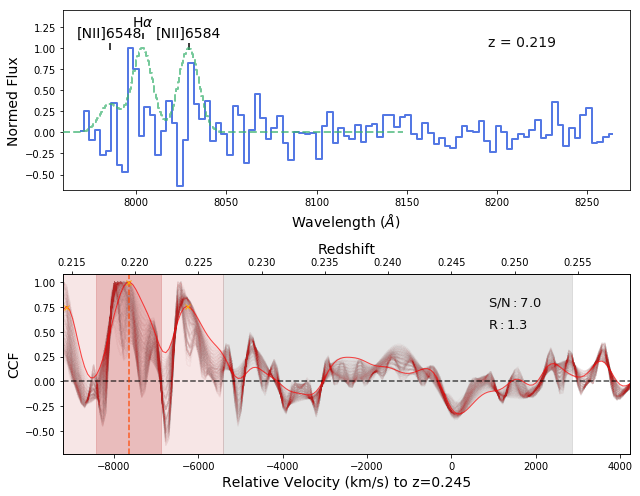

In [4]:
result = datacube.cross_correlation(10, temp_type="Ha-NII", const_window=False, edge=20, temp_model="gauss")

Detection #210  z: 0.246  sigma: 3.230  Peak R: 6.934  Detction S/N: 11.421 Peak S/N: 12.382


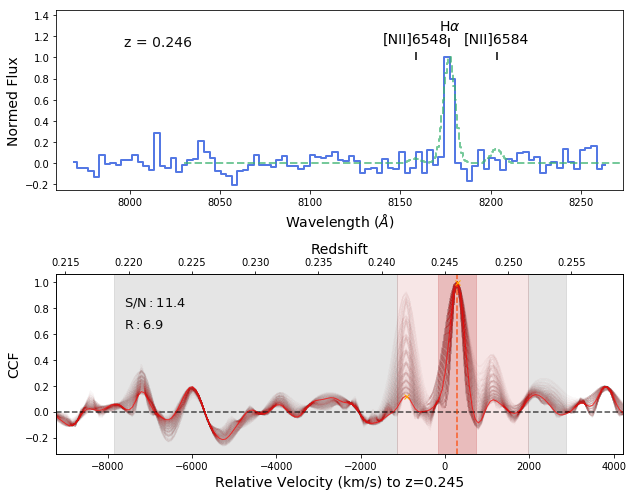

In [3]:
result = datacube.cross_correlation(210, temp_type="Ha-NII", edge=20, temp_model="gauss")

In [3]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="gauss", edge=20, verbose=False)

Do cross-correlation using Ha-NII_gauss model templates...
Do cross-correlation using Hb-OIII_gauss model templates...
Do cross-correlation using OII_gauss model templates...


In [4]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="box", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="box", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="box", edge=20, verbose=False)

Do cross-correlation using Ha-NII_box model templates...
Do cross-correlation using Hb-OIII_box model templates...
Do cross-correlation using OII_box model templates...


In [5]:
datacube.save_cc_result(save_path='./proc/A2465C/')

Save cross-correlation results for A2465C as : ./proc/A2465C/A2465C-cc.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss', 'Ha-NII_box', 'Hb-OIII_box', 'OII_box']


## 5. Select Candidate

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [6]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA.fits',
                         mask_edge='./proc/A2465C/Raw_stack_A2465C_mask.fits')

datacube.deep_frame =  fits.open('./proc/A2465C/A2465C_DF.fits')[0].data
datacube.src_map = fits.open('./proc/A2465C/A2465C_MMA.fits')[0].data
datacube.read_spec('./proc/A2465C/A2465C-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2465C')
datacube.read_cc_result('./proc/A2465C/A2465C-cc.pkl')

Read Emission Line Template:
['./proc/template/Template-A2465C_Ha-NII_gauss.fits',
 './proc/template/Template-A2465C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2465C_OII_gauss.fits',
 './proc/template/Template-A2465C_Ha-NII_box.fits',
 './proc/template/Template-A2465C_Hb-OIII_box.fits',
 './proc/template/Template-A2465C_OII_box.fits']
Read cross-correlation results for A2465C from : ./proc/A2465C/A2465C-cc.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss', 'Ha-NII_box', 'Hb-OIII_box', 'OII_box']


In [7]:
SNR_best_Ha_gauss = datacube.get_CC_result_best('SNR', 'Ha-NII_gauss')
SNR_best_OIII_gauss = datacube.get_CC_result_best('SNR', 'Hb-OIII_gauss')
SNR_best_OII_gauss = datacube.get_CC_result_best('SNR', 'OII_gauss')

SNR_best_Ha_box = datacube.get_CC_result_best('SNR', 'Ha-NII_box')
SNR_best_OII_box = datacube.get_CC_result_best('SNR', 'OII_box')

z_best_OIII_gauss = datacube.get_CC_result_best('z_best', 'Hb-OIII_gauss')
flag_e_Ha_gauss = datacube.get_CC_result_best('flag_e', 'Ha-NII_gauss')


### Match with SDSS stars

In [8]:
cat_match = datacube.match_sdss_star(sep=3*u.arcsec, search_radius=7*u.arcmin, band='rmag')

c_match_star = SkyCoord(ra=cat_match["RA_ICRS"], dec=cat_match["DE_ICRS"])
star_match_pos = np.array(c_match_star.to_pixel(datacube.wcs, origin=0)).T

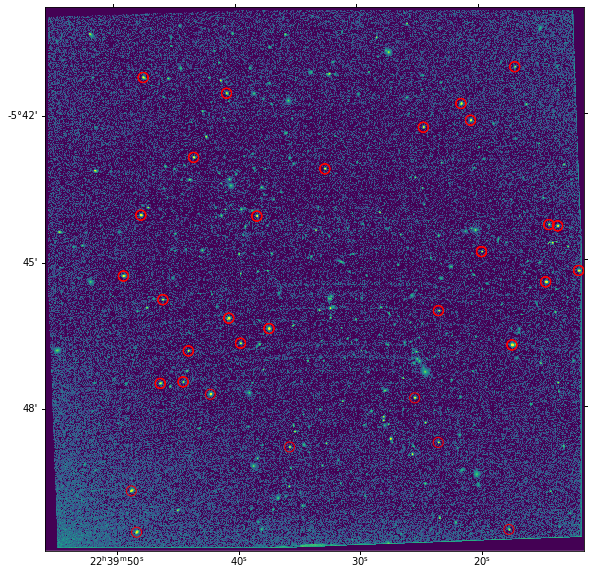

In [9]:
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=datacube.wcs)
plt.scatter(star_match_pos[:,0], star_match_pos[:,1], s=100, facecolor="none", edgecolor="r")
plt.imshow(datacube.src_map, norm=norm1, origin="lower", vmin=np.median(datacube.src_map), vmax=1)

### Measure distance

In [10]:
dist_to_edge = measure_dist_to_edge(datacube.table, datacube.mask_edge, pad=200)

### Measure EW

(81.57498578681299, 10.307183804704824)

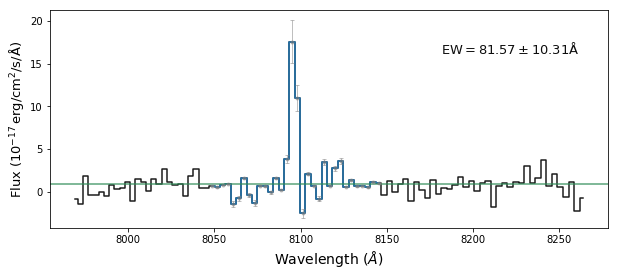

In [11]:
datacube.estimate_EW(152, sigma=5, MC_err=True)

(146.900818260249, 20.99080315110287)

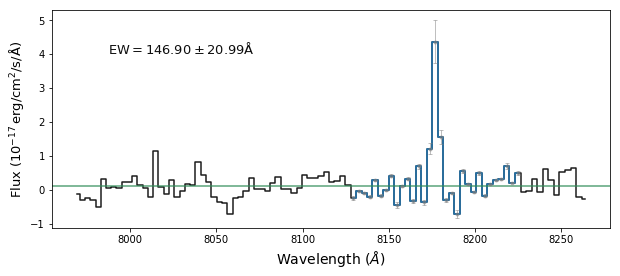

In [52]:
datacube.estimate_EW(210, sigma=5, MC_err=True)

In [55]:
datacube.estimate_EW_all(MC_err=True, sigma=5)

Measure EW... 400/1239
Measure EW... 800/1239
Measure EW... 1200/1239


In [56]:
bad_channel = datacube.get_channel([[7986,8006],[8016,8036]])
max_channel = np.argmax(datacube.obj_specs_opt, axis=1) + 1
strong_sky = np.array([max_ch in bad_channel for max_ch in max_channel])
low_cont = np.median(datacube.obj_specs_opt, axis=1) < 0.1
good_line = ~(strong_sky & low_cont) & (max_channel!=10)

### Conditions

In [70]:
EW_cond = (datacube.EWs > datacube.EW_stds) & (datacube.EWs > 5)
edge_cond = dist_to_edge > 5

SNR_min_gauss = np.min([SNR_best_Ha_gauss, SNR_best_OIII_gauss, SNR_best_OII_gauss], axis=0)

SNR_cond_A = (SNR_best_Ha_gauss > 8) & (SNR_best_OII_gauss>3)
SNR_cond_B = (SNR_best_Ha_gauss > 5) & (SNR_best_Ha_gauss <= 8) & (SNR_best_OII_gauss>5)

zmin_OIII = datacube.wavl.min()/4959-1
# SN OIII > 5, SN OIII > SN Ha, SN OIII > SN OII 
SNR_cond_C = (SNR_best_OIII_gauss > np.max([5*np.ones_like(datacube.obj_nums),
                                            SNR_best_Ha_gauss, SNR_best_OII_gauss], axis=0)) \
            & (SNR_best_OII_gauss>3) & (z_best_OIII_gauss>zmin_OIII)

v = 'C'
SN_cond_v = {'A':SNR_cond_A, 'B':SNR_cond_B, 'C':SNR_cond_C}
type_v = {'A':"Ha-NII", 'B':"Ha-NII", 'C':"Hb-OIII"}

num_c = datacube.obj_nums[EW_cond & SN_cond_v[v] & edge_cond & good_line]

# remove stars and possible artifacts
num_c = np.setdiff1d(num_c, cat_match["NUMBER"])
num_c = np.setdiff1d(num_c, datacube.num_spurious)
print("%s: %d candidates:"%(v,len(num_c)), num_c)

save_path = './A2465C/fig_iso/candidate/%s'%v
check_save_path(save_path, clear=True)
for k, num in enumerate(num_c):
    if np.mod(k+1, 40)==0: print("Plot: %d/%d"%(k+1, len(num_c)))
    datacube.plot_candidate(num, temp_type=type_v[v], temp_model="gauss")
    plt.savefig(os.path.join(save_path, "#%d.png"%num),dpi=75)
    plt.title("Sample %s"%v)
    plt.close()

C: 8 candidates: [ 24  93 196 428 537 591 629 676]
./A2465C/fig_iso/candidate/C exists. Remove all the content.


Detection #93  z: 0.247  sigma: 5.607  Peak R: 4.592  Detction S/N: 6.301 Peak S/N: 6.768


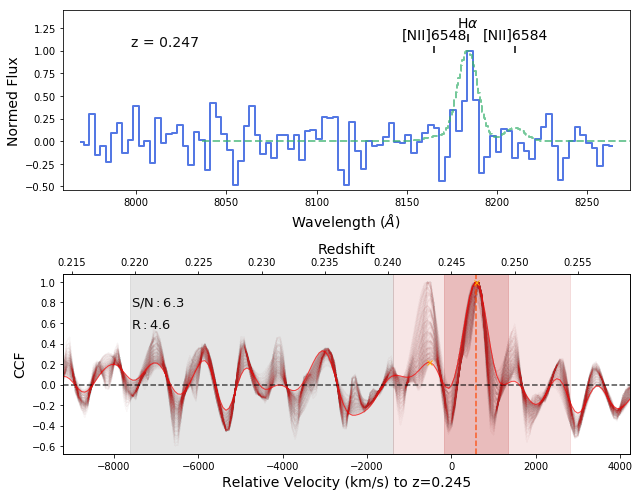

In [63]:
result = datacube.cross_correlation(93, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

Detection #428  z: 0.251  sigma: 1.804  Peak R: 6.234  Detction S/N: 15.559 Peak S/N: 15.423


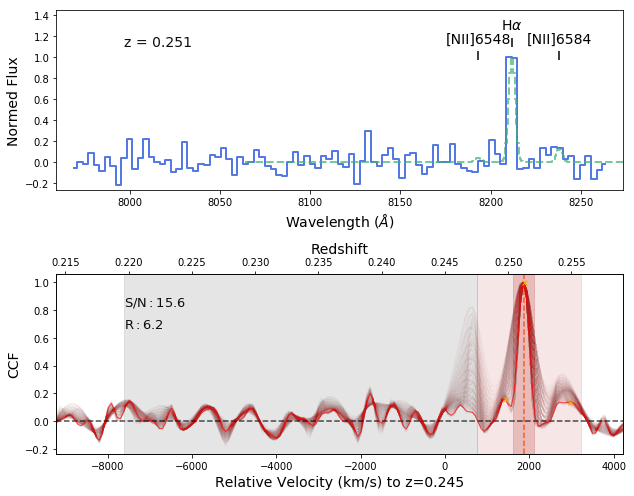

In [27]:
result = datacube.cross_correlation(428, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

## 6. Measure Centroid

In [2]:
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
datacube = Read_Datacube('./proc/A2465C/A2465C_cube.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA.fits',
                         deep_frame='./proc/A2465C/A2465C_DF.fits',
                         mask_edge='./proc/A2465C/Raw_stack_A2465C_mask.fits')

datacube.get_wcs()
datacube.read_cluster_boundary("./A2465C/A2465C_bound_v2.fits")
datacube.src_map = fits.open('./proc/A2465C/A2465C_MMA.fits')[0].data
datacube.read_spec('./proc/A2465C/A2465C-spec-MMA_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2465C')
datacube.read_cc_result('./proc/A2465C/A2465C-cc.pkl')

Read Emission Line Template:
['./proc/template/Template-A2465C_Ha-NII_gauss.fits',
 './proc/template/Template-A2465C_Hb-OIII_gauss.fits',
 './proc/template/Template-A2465C_OII_gauss.fits',
 './proc/template/Template-A2465C_Ha-NII_box.fits',
 './proc/template/Template-A2465C_Hb-OIII_box.fits',
 './proc/template/Template-A2465C_OII_box.fits']
Read cross-correlation results for A2465C from : ./proc/A2465C/A2465C-cc.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss', 'Ha-NII_box', 'Hb-OIII_box', 'OII_box']


In [78]:
el_v = glob.glob("./A2465C/fig_iso/candidate/V/#*.png")
Num_v_all = np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_v]).astype("int"))
Num_non = [428, 629]
Num_v = np.setdiff1d(Num_v_all, Num_non)
Num_v

array([   9,   24,   28,   46,   52,   93,   94,   99,  101,  122,  127,
        129,  132,  143,  152,  153,  174,  176,  178,  180,  187,  196,
        201,  210,  212,  217,  218,  249,  258,  277,  290,  298,  311,
        320,  324,  341,  348,  366,  373,  378,  383,  386,  387,  398,
        399,  401,  403,  414,  418,  422,  423,  426,  436,  437,  439,
        445,  451,  456,  457,  459,  467,  475,  478,  481,  492,  493,
        494,  499,  502,  518,  524,  536,  538,  555,  570,  581,  601,
        609,  614,  626,  627,  648,  659,  667,  673,  676,  705,  709,
        712,  716,  734,  740,  742,  765,  799,  813,  839,  854,  893,
        894,  957,  961,  967,  975, 1014, 1031, 1033, 1034, 1053, 1190,
       1191, 1192, 1198, 1205, 1214, 1215, 1223, 1224, 1225, 1228])

In [79]:
id_BCG1 = np.argmin((datacube.table["xcentroid"]-707)**2 + (datacube.table["ycentroid"]-1385)**2)
id_BCG2 = np.argmin((datacube.table["xcentroid"]-1446)**2 + (datacube.table["ycentroid"]-679)**2)
pos_BCG = datacube.assign_BCG_position(id_BCG=[id_BCG1,id_BCG2])

ra_BCG1, dec_BCG1 = datacube.wcs.all_pix2world(datacube.pos_BCG[0][0], datacube.pos_BCG[0][1], 0)
ra_BCG2, dec_BCG2 = datacube.wcs.all_pix2world(datacube.pos_BCG[1][0], datacube.pos_BCG[1][1], 0)
datacube.assign_BCG_coordinate(((ra_BCG1,dec_BCG1),(ra_BCG2,dec_BCG2)))

BCG1 coordinate:  22h39m40.4747s -05d43m26.2065s
BCG2 coordinate:  22h39m24.5529s -05d47m17.5801s


Error of light-wighted centroid: $\sigma_{\left<x\right>} = \Sigma_j \frac{\sigma^2_{I_j} \cdot (x_j-\left<x\right>)^2}{\Sigma_i I_i^2}$

http://ugastro.berkeley.edu/infrared09/PDF-2009/centroid-error.pdf

stddev emission: 0.018 / continuum: 0.005
Centroid EM: (1167.10+/-0.05, 41.94+/-0.03)
Centroid CON: (1166.51+/-0.04, 42.28+/-0.02)


{'diff_angle': 83.8815248396981,
 'cen_offset': 0.6797347182680517,
 'diff_angle_std': 3.78212168173884,
 'cen_offset_std': 0.05842822113777647,
 'pa': 59.62645392796975,
 'clus_cen_angle': 335.74492908827165,
 'dist_clus_cen': 690.1608630678054}

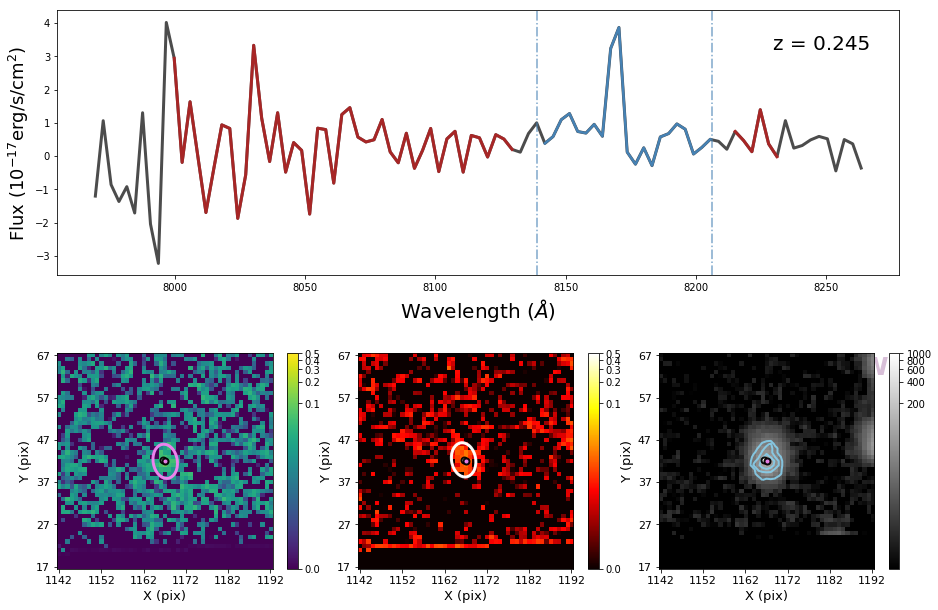

In [89]:
num = 9
datacube.centroid_analysis(num, centroid_type="APER", smooth=False)

stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1167.08+/-0.05, 42.17+/-0.03)
Centroid CON: (1166.66+/-0.07, 42.63+/-0.05)


{'diff_angle': 66.44949316960731,
 'cen_offset': 0.6244459754190765,
 'diff_angle_std': 6.918475090733244,
 'cen_offset_std': 0.07306721772213141,
 'pa': 42.194422257878955,
 'clus_cen_angle': 335.74492908827165,
 'dist_clus_cen': 690.1608630678054}

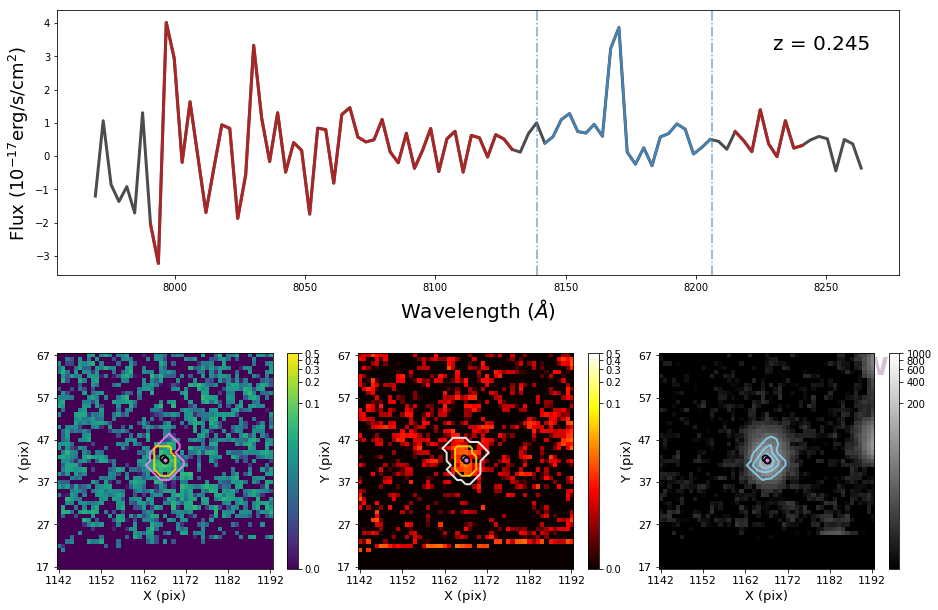

In [82]:
num = 9
datacube.centroid_analysis(num, centroid_type="ISO-D", smooth=False)

stddev emission: 0.016 / continuum: 0.004
Centroid EM: (843.16+/-0.15, 1233.84+/-0.15)
Centroid CON: (842.99+/-0.10, 1234.15+/-0.10)


{'diff_angle': 13.288737765888577,
 'cen_offset': 0.3443082252389126,
 'diff_angle_std': 29.48601548012825,
 'cen_offset_std': 0.17719067173197278,
 'pa': 28.583383547044832,
 'clus_cen_angle': 41.87212131293341,
 'dist_clus_cen': 206.4139509814216}

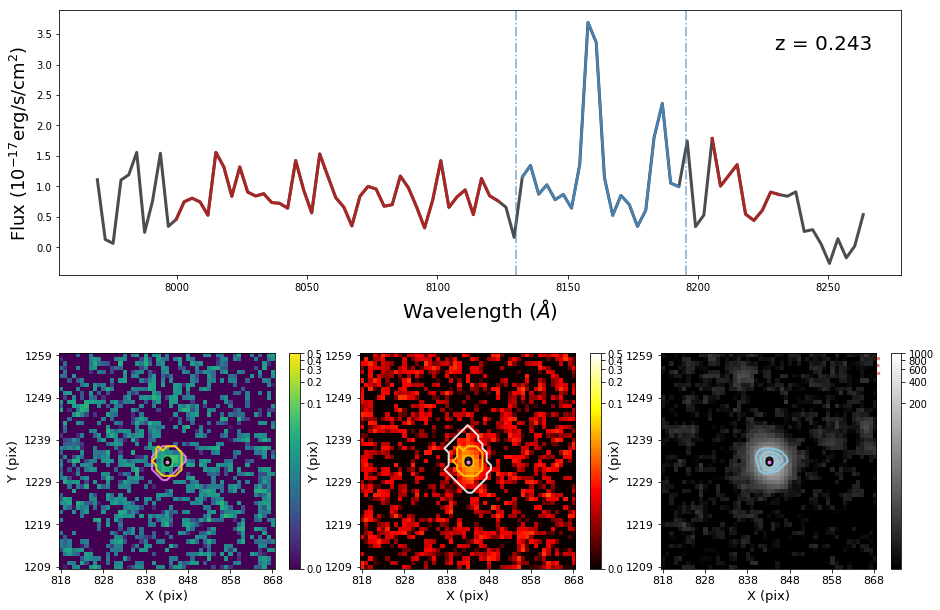

In [106]:
num = 667
datacube.centroid_analysis(num, centroid_type="ISO-D", morph_cen=True, smooth=False)

In [86]:
datacube.centroid_analysis_all(Num_v, nums_obj=Num_v, centroid_type="APER")


Candidate: #9
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1167.02+/-0.04, 42.00+/-0.02)
Centroid CON: (1166.77+/-0.03, 42.14+/-0.02)
Angle: 84.74 +/- 6.87
Offset: 0.29 +/- 0.04

Candidate: #24
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (1954.06+/-0.05, 91.84+/-0.06)
Centroid CON: (1952.10+/-0.06, 92.01+/-0.07)
Angle: 44.62 +/- 2.61
Offset: 1.96 +/- 0.08

Candidate: #28
stddev emission: 0.023 / continuum: 0.004
Centroid EM: (1558.36+/-0.13, 105.83+/-0.12)
Centroid CON: (1557.89+/-0.00, 107.68+/-0.00)
Angle: 3.52 +/- 3.95
Offset: 1.91 +/- 0.12

Candidate: #46
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (864.50+/-0.02, 156.64+/-0.02)
Centroid CON: (865.26+/-0.01, 156.71+/-0.01)
Angle: 35.74 +/- 1.74
Offset: 0.77 +/- 0.02

Candidate: #52
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1396.86+/-0.04, 169.97+/-0.02)
Centroid CON: (1396.78+/-0.08, 170.54+/-0.06)
Angle: 14.11 +/- 9.35
Offset: 0.57 +/- 0.06

Candidate: #93
stddev emission: 0.016 / co

Centroid EM: (1082.57+/-0.01, 884.50+/-0.01)
Centroid CON: (1082.52+/-0.00, 884.81+/-0.00)
Angle: 130.70 +/- 1.19
Offset: 0.31 +/- 0.01

Candidate: #445
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1382.67+/-0.06, 896.67+/-0.08)
Centroid CON: (1383.91+/-0.01, 896.65+/-0.02)
Angle: 74.79 +/- 3.72
Offset: 1.24 +/- 0.06

Candidate: #451
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1935.25+/-0.01, 905.99+/-0.01)
Centroid CON: (1935.39+/-0.00, 906.27+/-0.00)
Angle: 140.98 +/- 1.78
Offset: 0.31 +/- 0.01

Candidate: #456
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (1040.84+/-0.00, 913.16+/-0.00)
Centroid CON: (1041.74+/-0.01, 912.16+/-0.01)
Angle: 17.37 +/- 0.49
Offset: 1.35 +/- 0.01

Candidate: #457
stddev emission: 0.015 / continuum: 0.004

Candidate: #459
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (386.42+/-0.00, 922.62+/-0.00)
Centroid CON: (386.03+/-0.01, 922.88+/-0.01)
Angle: 91.45 +/- 1.00
Offset: 0.47 +/- 0.01

Candidate: #467
stddev emissi

Centroid EM: (1882.17+/-1.21, 1984.28+/-0.93)
Centroid CON: (1877.65+/-0.00, 1982.87+/-0.00)
Angle: 54.14 +/- 11.61
Offset: 4.73 +/- 1.18

Candidate: #1034
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (377.20+/-0.32, 1979.22+/-0.40)
Centroid CON: (378.85+/-0.14, 1980.67+/-0.17)
Angle: 103.17 +/- 10.38
Offset: 2.20 +/- 0.39

Candidate: #1053
stddev emission: 0.013 / continuum: 0.004

Candidate: #1190
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1785.85+/-0.01, 784.09+/-0.00)
Centroid CON: (1785.66+/-0.00, 783.55+/-0.00)
Angle: 52.93 +/- 0.61
Offset: 0.58 +/- 0.00

Candidate: #1191
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (803.18+/-0.03, 775.43+/-0.03)
Centroid CON: (804.49+/-0.02, 777.24+/-0.02)
Angle: 63.01 +/- 0.98
Offset: 2.24 +/- 0.04

Candidate: #1192
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (813.99+/-0.00, 783.93+/-0.01)
Centroid CON: (813.80+/-0.01, 784.57+/-0.01)
Angle: 116.92 +/- 0.66
Offset: 0.67 +/- 0.01

Candidate: #1198
stdde

In [84]:
datacube.centroid_analysis_all(Num_v, nums_obj=Num_v, centroid_type="ISO-D", morph_cen=False)


Candidate: #9
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1167.02+/-0.05, 42.19+/-0.03)
Centroid CON: (1166.51+/-0.05, 42.58+/-0.04)
Angle: 77.16 +/- 5.33
Offset: 0.64 +/- 0.07

Candidate: #24
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (1953.78+/-0.05, 91.91+/-0.08)
Centroid CON: (1951.84+/-0.10, 91.88+/-0.12)
Angle: 50.31 +/- 4.05
Offset: 1.95 +/- 0.11

Candidate: #28
stddev emission: 0.023 / continuum: 0.004
Centroid EM: (1558.52+/-0.25, 105.92+/-0.17)
Centroid CON: (1557.74+/-0.00, 107.91+/-0.00)
Angle: 10.76 +/- 6.59
Offset: 2.14 +/- 0.19

Candidate: #46
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (864.40+/-0.06, 156.19+/-0.04)
Centroid CON: (865.37+/-0.02, 156.85+/-0.01)
Angle: 7.35 +/- 2.36
Offset: 1.16 +/- 0.05

Candidate: #52
stddev emission: 0.016 / continuum: 0.004

Candidate: #93


stddev emission: 0.016 / continuum: 0.004

Candidate: #94
stddev emission: 0.017 / continuum: 0.004

Candidate: #99
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1442.08+/-0.02, 255.53+/-0.01)
Centroid CON: (1442.12+/-0.02, 255.35+/-0.01)
Angle: 164.86 +/- 7.03
Offset: 0.19 +/- 0.02

Candidate: #101
stddev emission: 0.019 / continuum: 0.005
Centroid EM: (1563.83+/-0.06, 260.03+/-0.05)
Centroid CON: (1563.07+/-0.04, 260.08+/-0.03)
Angle: 70.83 +/- 4.40
Offset: 0.76 +/- 0.08

Candidate: #122
stddev emission: 0.014 / continuum: 0.004

Candidate: #127
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1052.38+/-0.02, 323.60+/-0.01)
Centroid CON: (1052.14+/-0.02, 323.61+/-0.01)
Angle: 134.04 +/- 3.58
Offset: 0.25 +/- 0.03

Candidate: #129
stddev emission: 0.020 / continuum: 0.004

Candidate: #132
stddev emission: 0.015 / continuum: 0.002



Candidate: #143
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1003.97+/-0.09, 372.45+/-0.09)
Centroid CON: (1001.92+/-0.05, 373.06+/-0.11)
Angle: 129.07 +/- 3.69
Offset: 2.14 +/- 0.10

Candidate: #152
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1967.04+/-0.03, 397.91+/-0.01)
Centroid CON: (1966.33+/-0.04, 396.33+/-0.02)
Angle: 93.96 +/- 1.50
Offset: 1.74 +/- 0.03

Candidate: #153
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1397.62+/-0.03, 395.86+/-0.04)
Centroid CON: (1396.43+/-0.02, 399.64+/-0.02)
Angle: 27.25 +/- 0.58
Offset: 3.95 +/- 0.04

Candidate: #174
stddev emission: 0.017 / continuum: 0.004

Candidate: #176
stddev emission: 0.017 / continuum: 0.006

Candidate: #178
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (1646.65+/-0.74, 459.05+/-0.54)
Centroid CON: (1646.31+/-0.03, 458.87+/-0.02)
Angle: 75.73 +/- 87.90
Offset: 0.39 +/- 0.70

Candidate: #180
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (584.73+/-0.05, 464.70+/-0.06)
C

Centroid EM: (1948.64+/-0.02, 605.10+/-0.04)
Centroid CON: (1949.21+/-0.07, 605.85+/-0.07)
Angle: 119.05 +/- 4.84
Offset: 0.94 +/- 0.08

Candidate: #258
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (474.44+/-0.01, 623.24+/-0.01)
Centroid CON: (474.90+/-0.06, 625.17+/-0.03)
Angle: 3.85 +/- 1.59
Offset: 1.99 +/- 0.03

Candidate: #277
stddev emission: 0.013 / continuum: 0.003

Candidate: #290
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (538.02+/-0.01, 682.21+/-0.01)
Centroid CON: (538.56+/-0.01, 682.81+/-0.01)
Angle: 28.17 +/- 1.14
Offset: 0.81 +/- 0.02

Candidate: #298
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1158.66+/-0.07, 690.70+/-0.06)
Centroid CON: (1158.22+/-0.04, 690.88+/-0.03)
Angle: 159.88 +/- 7.73
Offset: 0.48 +/- 0.08

Candidate: #311
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1880.73+/-0.01, 712.77+/-0.01)
Centroid CON: (1880.05+/-0.02, 712.89+/-0.03)
Angle: 14.55 +/- 2.50
Offset: 0.69 +/- 0.02

Candidate: #320
stddev emission:

stddev emission: 0.017 / continuum: 0.005
Centroid EM: (1885.04+/-0.11, 742.78+/-0.09)
Centroid CON: (1884.17+/-0.11, 744.04+/-0.14)
Angle: 63.41 +/- 6.03
Offset: 1.53 +/- 0.17

Candidate: #348
stddev emission: 0.017 / continuum: 0.005
Centroid EM: (1408.86+/-0.02, 755.70+/-0.02)
Centroid CON: (1408.55+/-0.00, 755.89+/-0.00)
Angle: 144.27 +/- 3.15
Offset: 0.37 +/- 0.02

Candidate: #366
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1299.19+/-0.02, 782.45+/-0.04)
Centroid CON: (1299.23+/-0.03, 782.62+/-0.02)
Angle: 115.46 +/- 12.10
Offset: 0.18 +/- 0.04

Candidate: #373
stddev emission: 0.019 / continuum: 0.003

Candidate: #378
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1162.09+/-0.05, 790.10+/-0.03)
Centroid CON: (1162.22+/-0.02, 789.42+/-0.01)
Angle: 57.20 +/- 4.19
Offset: 0.69 +/- 0.03

Candidate: #383
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1401.48+/-0.08, 800.10+/-0.06)
Centroid CON: (1402.48+/-0.02, 800.78+/-0.03)
Angle: 106.76 +/- 3.53
Offset

stddev emission: 0.015 / continuum: 0.004
Centroid EM: (826.43+/-0.13, 821.73+/-0.10)
Centroid CON: (827.48+/-0.01, 822.70+/-0.02)
Angle: 56.11 +/- 4.57
Offset: 1.43 +/- 0.12

Candidate: #399
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1522.64+/-0.05, 824.30+/-0.07)
Centroid CON: (1522.87+/-0.02, 825.47+/-0.03)
Angle: 161.59 +/- 2.72
Offset: 1.19 +/- 0.07

Candidate: #401
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (547.78+/-0.16, 824.27+/-0.22)
Centroid CON: (547.95+/-0.02, 824.33+/-0.04)
Angle: 53.24 +/- 69.35
Offset: 0.18 +/- 0.17

Candidate: #403
stddev emission: 0.015 / continuum: 0.003

Candidate: #414
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1769.39+/-0.15, 842.51+/-0.28)
Centroid CON: (1768.87+/-0.03, 843.27+/-0.03)
Angle: 82.13 +/- 12.74
Offset: 0.92 +/- 0.25

Candidate: #418
stddev emission: 0.017 / continuum: 0.004

Candidate: #422
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (940.72+/-0.01, 855.04+/-0.01)
Centroid CON: (941.90

Centroid EM: (1198.95+/-0.36, 851.20+/-0.39)
Centroid CON: (1198.17+/-0.03, 851.94+/-0.08)
Angle: 172.54 +/- 20.15
Offset: 1.08 +/- 0.38

Candidate: #426
stddev emission: 0.016 / continuum: 0.004

Candidate: #436
stddev emission: 0.017 / continuum: 0.004

Candidate: #437
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1178.31+/-0.02, 878.93+/-0.03)
Centroid CON: (1178.52+/-0.01, 878.32+/-0.01)
Angle: 33.81 +/- 2.11
Offset: 0.65 +/- 0.03

Candidate: #439
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1082.47+/-0.01, 884.50+/-0.01)
Centroid CON: (1082.74+/-0.01, 884.96+/-0.01)
Angle: 90.50 +/- 1.43
Offset: 0.53 +/- 0.01

Candidate: #445
stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1382.72+/-0.05, 896.64+/-0.08)
Centroid CON: (1384.11+/-0.02, 896.44+/-0.03)
Angle: 67.14 +/- 3.37
Offset: 1.40 +/- 0.05

Candidate: #451
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1935.24+/-0.01, 905.87+/-0.02)
Centroid CON: (1935.18+/-0.01, 906.26+/-0.01)
Angle: 105.19


Candidate: #499
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (632.81+/-0.02, 972.57+/-0.01)
Centroid CON: (632.98+/-0.02, 972.58+/-0.03)
Angle: 76.68 +/- 10.30
Offset: 0.17 +/- 0.03

Candidate: #502
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (591.13+/-0.09, 975.62+/-0.20)
Centroid CON: (588.42+/-0.09, 975.29+/-0.14)
Angle: 113.09 +/- 5.19
Offset: 2.73 +/- 0.13

Candidate: #518
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (1839.25+/-0.03, 999.43+/-0.03)
Centroid CON: (1839.42+/-0.01, 999.23+/-0.01)
Angle: 89.98 +/- 7.32
Offset: 0.26 +/- 0.03

Candidate: #524
stddev emission: 0.015 / continuum: 0.004

Candidate: #536
stddev emission: 0.015 / continuum: 0.004

Candidate: #538
stddev emission: 0.018 / continuum: 0.004

Candidate: #555
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (1219.32+/-0.06, 1046.22+/-0.05)
Centroid CON: (1218.77+/-0.02, 1045.72+/-0.02)
Angle: 78.50 +/- 4.58
Offset: 0.74 +/- 0.06

Candidate: #570


stddev emission: 0.014 / continuum: 0.004
Centroid EM: (1534.65+/-0.39, 1077.65+/-0.42)
Centroid CON: (1539.17+/-0.00, 1078.19+/-0.00)
Angle: 110.93 +/- 5.33
Offset: 4.56 +/- 0.39

Candidate: #581
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1503.13+/-0.03, 1090.44+/-0.05)
Centroid CON: (1501.80+/-0.07, 1089.90+/-0.07)
Angle: 59.03 +/- 3.49
Offset: 1.44 +/- 0.08

Candidate: #601
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1168.76+/-0.02, 1125.89+/-0.02)
Centroid CON: (1167.77+/-0.02, 1125.71+/-0.02)
Angle: 110.70 +/- 1.49
Offset: 1.01 +/- 0.03

Candidate: #609
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (534.56+/-0.04, 1144.25+/-0.03)
Centroid CON: (533.77+/-0.03, 1144.06+/-0.02)
Angle: 139.79 +/- 2.96
Offset: 0.81 +/- 0.05

Candidate: #614
stddev emission: 0.017 / continuum: 0.004

Candidate: #626


stddev emission: 0.019 / continuum: 0.004

Candidate: #627
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (1939.37+/-0.02, 1173.93+/-0.02)
Centroid CON: (1939.56+/-0.01, 1174.09+/-0.01)
Angle: 175.64 +/- 5.50
Offset: 0.25 +/- 0.02

Candidate: #648
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (278.78+/-0.16, 1207.85+/-0.11)
Centroid CON: (281.44+/-0.01, 1209.36+/-0.01)
Angle: 7.17 +/- 2.33
Offset: 3.05 +/- 0.15

Candidate: #659
stddev emission: 0.015 / continuum: 0.005

Candidate: #667
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (843.54+/-0.05, 1234.21+/-0.04)
Centroid CON: (843.25+/-0.01, 1233.82+/-0.01)
Angle: 100.84 +/- 5.47
Offset: 0.49 +/- 0.04

Candidate: #673
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1206.43+/-0.06, 1240.28+/-0.06)
Centroid CON: (1206.48+/-0.01, 1240.71+/-0.02)
Angle: 151.56 +/- 8.50
Offset: 0.44 +/- 0.06

Candidate: #676
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (775.15+/-0.10, 1244.96+/-0.07)
Centroid CON:

stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1504.25+/-0.01, 1473.03+/-0.02)
Centroid CON: (1504.35+/-0.01, 1472.81+/-0.01)
Angle: 29.27 +/- 3.97
Offset: 0.24 +/- 0.02

Candidate: #839
stddev emission: 0.014 / continuum: 0.004

Candidate: #854
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (611.15+/-0.00, 1571.14+/-0.00)
Centroid CON: (611.04+/-0.01, 1570.41+/-0.01)
Angle: 34.90 +/- 0.75
Offset: 0.74 +/- 0.01

Candidate: #893
stddev emission: 0.016 / continuum: 0.004

Candidate: #894
stddev emission: 0.017 / continuum: 0.004

Candidate: #957
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (180.76+/-0.05, 1796.35+/-0.04)
Centroid CON: (180.88+/-0.01, 1796.29+/-0.02)
Angle: 10.29 +/- 19.09
Offset: 0.14 +/- 0.05

Candidate: #961
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (1077.07+/-0.00, 1810.07+/-0.01)
Centroid CON: (1075.50+/-0.00, 1809.39+/-0.01)
Angle: 24.92 +/- 0.36
Offset: 1.71 +/- 0.01

Candidate: #967
stddev emission: 0.014 / continuum: 0.005


stddev emission: 0.015 / continuum: 0.004
Centroid EM: (514.52+/-0.05, 1832.60+/-0.02)
Centroid CON: (514.71+/-0.01, 1830.76+/-0.01)
Angle: 16.57 +/- 1.52
Offset: 1.85 +/- 0.02

Candidate: #1014
stddev emission: 0.016 / continuum: 0.004

Candidate: #1031
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (711.91+/-0.05, 1963.18+/-0.03)
Centroid CON: (710.98+/-0.01, 1964.06+/-0.01)
Angle: 132.19 +/- 1.75
Offset: 1.28 +/- 0.04

Candidate: #1033
stddev emission: 0.021 / continuum: 0.004
Centroid EM: (1882.26+/-0.24, 1984.71+/-0.28)
Centroid CON: (1877.43+/-0.00, 1982.79+/-0.00)
Angle: 49.78 +/- 3.05
Offset: 5.20 +/- 0.24

Candidate: #1034
stddev emission: 0.018 / continuum: 0.004

Candidate: #1053
stddev emission: 0.013 / continuum: 0.004

Candidate: #1190
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1785.81+/-0.02, 784.20+/-0.01)
Centroid CON: (1784.78+/-0.00, 783.30+/-0.00)
Angle: 24.54 +/- 0.56
Offset: 1.37 +/- 0.01

Candidate: #1191
stddev emission: 0.017 / continuum: 0

In [92]:
datacube.centroid_analysis_all(Num_v, nums_obj=Num_v, centroid_type="ISO-D", morph_cen=True)


Candidate: #9
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1167.10+/-0.13, 42.47+/-0.13)
Centroid CON: (1166.45+/-0.12, 42.55+/-0.12)
Angle: 107.06 +/- 15.29
Offset: 0.65 +/- 0.17

Candidate: #24
stddev emission: 0.016 / continuum: 0.006

Candidate: #28
stddev emission: 0.027 / continuum: 0.004
Centroid EM: (1558.62+/-0.14, 105.90+/-0.14)
Centroid CON: (1557.24+/-0.08, 109.21+/-0.08)
Angle: 12.06 +/- 2.56
Offset: 3.59 +/- 0.16

Candidate: #46
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (864.52+/-0.12, 156.34+/-0.12)
Centroid CON: (865.28+/-0.08, 156.57+/-0.08)
Angle: 24.37 +/- 10.36
Offset: 0.79 +/- 0.14

Candidate: #52
stddev emission: 0.017 / continuum: 0.005
Centroid EM: (1396.54+/-0.14, 170.09+/-0.14)
Centroid CON: (1398.00+/-0.19, 169.59+/-0.19)
Angle: 103.17 +/- 8.52
Offset: 1.55 +/- 0.23

Candidate: #93
stddev emission: 0.015 / continuum: 0.004

Candidate: #94


stddev emission: 0.017 / continuum: 0.004

Candidate: #99
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1442.26+/-0.10, 255.87+/-0.10)
Centroid CON: (1441.98+/-0.09, 255.18+/-0.09)
Angle: 158.82 +/- 10.01
Offset: 0.75 +/- 0.13

Candidate: #101
stddev emission: 0.019 / continuum: 0.005
Centroid EM: (1563.82+/-0.15, 259.91+/-0.15)
Centroid CON: (1563.11+/-0.12, 260.43+/-0.12)
Angle: 38.46 +/- 12.25
Offset: 0.88 +/- 0.19

Candidate: #122
stddev emission: 0.014 / continuum: 0.005

Candidate: #127
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1052.56+/-0.11, 323.61+/-0.11)
Centroid CON: (1052.61+/-0.10, 324.35+/-0.10)
Angle: 44.58 +/- 11.69
Offset: 0.74 +/- 0.15

Candidate: #129
stddev emission: 0.021 / continuum: 0.005

Candidate: #132
stddev emission: 0.017 / continuum: 0.004

Candidate: #143
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1003.75+/-0.18, 372.28+/-0.18)
Centroid CON: (1002.51+/-0.13, 372.53+/-0.13)
Angle: 134.46 +/- 10.07
Offset: 1.27 +/- 0.22


stddev emission: 0.018 / continuum: 0.005
Centroid EM: (1966.91+/-0.08, 397.58+/-0.08)
Centroid CON: (1966.17+/-0.10, 396.58+/-0.10)
Angle: 81.85 +/- 5.85
Offset: 1.25 +/- 0.13

Candidate: #153
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1397.82+/-0.10, 395.34+/-0.10)
Centroid CON: (1396.24+/-0.08, 399.74+/-0.08)
Angle: 29.48 +/- 1.53
Offset: 4.68 +/- 0.12

Candidate: #174
stddev emission: 0.017 / continuum: 0.004

Candidate: #176
stddev emission: 0.017 / continuum: 0.005

Candidate: #178
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (1646.81+/-0.18, 458.66+/-0.18)
Centroid CON: (1646.51+/-0.13, 458.68+/-0.13)
Angle: 43.48 +/- 41.27
Offset: 0.30 +/- 0.22

Candidate: #180
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (585.20+/-0.13, 465.08+/-0.13)
Centroid CON: (583.36+/-0.07, 464.71+/-0.07)
Angle: 178.05 +/- 4.51
Offset: 1.88 +/- 0.15

Candidate: #187
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (942.92+/-0.09, 476.38+/-0.09)
Centroid CON: (942.5

Centroid EM: (833.77+/-0.16, 494.23+/-0.16)
Centroid CON: (832.13+/-0.14, 494.12+/-0.14)
Angle: 167.70 +/- 7.41
Offset: 1.64 +/- 0.21

Candidate: #210
stddev emission: 0.018 / continuum: 0.005
Centroid EM: (1221.73+/-0.15, 517.77+/-0.15)
Centroid CON: (1222.51+/-0.16, 518.08+/-0.16)
Angle: 14.45 +/- 15.13
Offset: 0.84 +/- 0.22

Candidate: #212
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1237.40+/-0.10, 530.76+/-0.10)
Centroid CON: (1238.10+/-0.07, 530.42+/-0.07)
Angle: 61.18 +/- 9.03
Offset: 0.77 +/- 0.12

Candidate: #217
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1476.18+/-0.17, 533.82+/-0.17)
Centroid CON: (1477.29+/-0.12, 533.69+/-0.12)
Angle: 109.55 +/- 10.54
Offset: 1.12 +/- 0.21

Candidate: #218
stddev emission: 0.015 / continuum: 0.005

Candidate: #249
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1948.25+/-0.13, 605.02+/-0.13)
Centroid CON: (1949.10+/-0.14, 605.67+/-0.14)
Angle: 134.53 +/- 10.43
Offset: 1.08 +/- 0.20

Candidate: #258
stddev em

Centroid EM: (1162.00+/-0.16, 791.00+/-0.16)
Centroid CON: (1161.81+/-0.10, 789.44+/-0.10)
Angle: 75.14 +/- 7.04
Offset: 1.57 +/- 0.19

Candidate: #383
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1401.35+/-0.14, 799.70+/-0.14)
Centroid CON: (1402.59+/-0.12, 800.77+/-0.12)
Angle: 113.28 +/- 6.26
Offset: 1.63 +/- 0.18

Candidate: #386
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1906.16+/-0.16, 802.61+/-0.16)
Centroid CON: (1904.04+/-0.12, 800.97+/-0.12)
Angle: 22.81 +/- 4.28
Offset: 2.67 +/- 0.20

Candidate: #387
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (1148.42+/-0.10, 806.62+/-0.10)
Centroid CON: (1146.86+/-0.09, 806.48+/-0.09)
Angle: 151.14 +/- 5.03
Offset: 1.56 +/- 0.14

Candidate: #398
stddev emission: 0.015 / continuum: 0.004
Centroid EM: (825.74+/-0.15, 821.51+/-0.15)
Centroid CON: (827.09+/-0.11, 822.76+/-0.11)
Angle: 56.32 +/- 5.65
Offset: 1.84 +/- 0.18

Candidate: #399
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1522.65+/-0.18, 

stddev emission: 0.017 / continuum: 0.004

Candidate: #422
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (940.91+/-0.09, 855.13+/-0.09)
Centroid CON: (942.71+/-0.08, 856.34+/-0.08)
Angle: 53.61 +/- 3.12
Offset: 2.17 +/- 0.12

Candidate: #423
stddev emission: 0.019 / continuum: 0.004
Centroid EM: (1198.00+/-0.18, 851.10+/-0.18)
Centroid CON: (1199.03+/-0.16, 851.92+/-0.16)
Angle: 74.44 +/- 10.65
Offset: 1.31 +/- 0.24

Candidate: #426
stddev emission: 0.016 / continuum: 0.005

Candidate: #436
stddev emission: 0.018 / continuum: 0.004

Candidate: #437
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1178.29+/-0.09, 878.61+/-0.09)
Centroid CON: (1178.46+/-0.09, 877.70+/-0.09)
Angle: 42.03 +/- 7.97
Offset: 0.93 +/- 0.13

Candidate: #439
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1082.45+/-0.11, 884.42+/-0.11)
Centroid CON: (1082.97+/-0.09, 884.82+/-0.09)
Angle: 68.36 +/- 12.36
Offset: 0.65 +/- 0.14

Candidate: #445
stddev emission: 0.014 / continuum: 0.005
Centr

stddev emission: 0.016 / continuum: 0.005

Candidate: #499
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (633.02+/-0.13, 971.80+/-0.13)
Centroid CON: (632.61+/-0.13, 972.85+/-0.13)
Angle: 31.35 +/- 9.19
Offset: 1.13 +/- 0.18

Candidate: #502
stddev emission: 0.016 / continuum: 0.005

Candidate: #518
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1839.65+/-0.12, 999.86+/-0.12)
Centroid CON: (1838.84+/-0.12, 999.21+/-0.12)
Angle: 0.20 +/- 9.10
Offset: 1.04 +/- 0.16

Candidate: #524
stddev emission: 0.015 / continuum: 0.004

Candidate: #536
stddev emission: 0.015 / continuum: 0.004

Candidate: #538
stddev emission: 0.018 / continuum: 0.004

Candidate: #555


stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1218.82+/-0.14, 1046.57+/-0.14)
Centroid CON: (1219.11+/-0.09, 1046.16+/-0.09)
Angle: 4.75 +/- 19.55
Offset: 0.50 +/- 0.17

Candidate: #570
stddev emission: 0.015 / continuum: 0.005

Candidate: #581
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1502.57+/-0.13, 1090.67+/-0.13)
Centroid CON: (1503.00+/-0.16, 1091.00+/-0.16)
Angle: 136.12 +/- 22.27
Offset: 0.54 +/- 0.21

Candidate: #601
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1168.71+/-0.12, 1125.67+/-0.12)
Centroid CON: (1168.63+/-0.09, 1126.13+/-0.09)
Angle: 158.46 +/- 18.30
Offset: 0.47 +/- 0.15

Candidate: #609
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (534.54+/-0.13, 1144.28+/-0.13)
Centroid CON: (533.51+/-0.11, 1143.76+/-0.11)
Angle: 152.07 +/- 8.46
Offset: 1.16 +/- 0.17

Candidate: #614
stddev emission: 0.017 / continuum: 0.004

Candidate: #626


stddev emission: 0.021 / continuum: 0.004

Candidate: #627
stddev emission: 0.015 / continuum: 0.005
Centroid EM: (1939.64+/-0.14, 1173.74+/-0.14)
Centroid CON: (1939.93+/-0.09, 1173.37+/-0.09)
Angle: 83.22 +/- 20.44
Offset: 0.46 +/- 0.16

Candidate: #648
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (283.16+/-0.16, 1215.59+/-0.16)
Centroid CON: (281.00+/-0.06, 1209.18+/-0.06)
Angle: 130.95 +/- 1.50
Offset: 6.77 +/- 0.18

Candidate: #659
stddev emission: 0.016 / continuum: 0.005

Candidate: #667
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (843.16+/-0.15, 1233.84+/-0.15)
Centroid CON: (842.99+/-0.10, 1234.15+/-0.10)
Angle: 13.29 +/- 29.49
Offset: 0.34 +/- 0.18

Candidate: #673
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1206.57+/-0.15, 1240.36+/-0.15)
Centroid CON: (1206.36+/-0.09, 1240.33+/-0.09)
Angle: 104.93 +/- 43.96
Offset: 0.22 +/- 0.17

Candidate: #676
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (775.09+/-0.15, 1245.43+/-0.15)
Centroid C

stddev emission: 0.016 / continuum: 0.004
Centroid EM: (1799.90+/-0.12, 1269.96+/-0.12)
Centroid CON: (1799.09+/-0.15, 1269.93+/-0.15)
Angle: 57.04 +/- 13.69
Offset: 0.81 +/- 0.19

Candidate: #709
stddev emission: 0.018 / continuum: 0.003
Centroid EM: (1398.40+/-0.14, 1275.26+/-0.14)
Centroid CON: (1397.64+/-0.15, 1275.66+/-0.15)
Angle: 121.19 +/- 13.65
Offset: 0.86 +/- 0.20

Candidate: #712
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1165.66+/-0.13, 1281.57+/-0.13)
Centroid CON: (1165.71+/-0.14, 1282.37+/-0.14)
Angle: 152.05 +/- 14.05
Offset: 0.80 +/- 0.20

Candidate: #716
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (803.70+/-0.12, 1289.09+/-0.12)
Centroid CON: (803.26+/-0.11, 1289.17+/-0.11)
Angle: 35.21 +/- 21.13
Offset: 0.45 +/- 0.17

Candidate: #734
stddev emission: 0.016 / continuum: 0.004

Candidate: #740
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (1890.04+/-0.12, 1340.40+/-0.12)
Centroid CON: (1889.06+/-0.10, 1340.01+/-0.10)
Angle: 34.23 +/- 8

Centroid EM: (791.60+/-0.16, 1453.15+/-0.16)
Centroid CON: (791.36+/-0.08, 1452.45+/-0.08)
Angle: 33.64 +/- 13.63
Offset: 0.74 +/- 0.18

Candidate: #813
stddev emission: 0.018 / continuum: 0.004
Centroid EM: (1503.87+/-0.12, 1473.15+/-0.12)
Centroid CON: (1504.43+/-0.11, 1472.52+/-0.11)
Angle: 46.91 +/- 11.07
Offset: 0.84 +/- 0.16

Candidate: #839
stddev emission: 0.014 / continuum: 0.005

Candidate: #854
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (611.34+/-0.08, 1570.83+/-0.08)
Centroid CON: (611.44+/-0.07, 1570.00+/-0.07)
Angle: 19.25 +/- 7.42
Offset: 0.84 +/- 0.11

Candidate: #893
stddev emission: 0.016 / continuum: 0.004

Candidate: #894
stddev emission: 0.018 / continuum: 0.004

Candidate: #957
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (180.14+/-0.13, 1795.86+/-0.13)
Centroid CON: (180.75+/-0.09, 1796.45+/-0.09)
Angle: 82.51 +/- 10.92
Offset: 0.85 +/- 0.16

Candidate: #961
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1074.77+/-0.07, 1809.39+/-0.


Candidate: #975
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (514.08+/-0.10, 1831.91+/-0.10)
Centroid CON: (514.92+/-0.07, 1830.28+/-0.07)
Angle: 4.80 +/- 3.75
Offset: 1.83 +/- 0.12

Candidate: #1014
stddev emission: 0.016 / continuum: 0.004

Candidate: #1031
stddev emission: 0.016 / continuum: 0.004
Centroid EM: (711.37+/-0.11, 1963.74+/-0.11)
Centroid CON: (710.98+/-0.07, 1964.33+/-0.07)
Angle: 145.28 +/- 10.86
Offset: 0.71 +/- 0.13

Candidate: #1033
stddev emission: 0.024 / continuum: 0.004

Candidate: #1034
stddev emission: 0.019 / continuum: 0.005

Candidate: #1053
stddev emission: 0.013 / continuum: 0.005

Candidate: #1190
stddev emission: 0.016 / continuum: 0.005
Centroid EM: (1786.17+/-0.08, 783.37+/-0.08)
Centroid CON: (1786.66+/-0.06, 783.47+/-0.06)
Angle: 173.91 +/- 11.80
Offset: 0.50 +/- 0.10

Candidate: #1191
stddev emission: 0.017 / continuum: 0.004
Centroid EM: (802.25+/-0.11, 775.54+/-0.11)
Centroid CON: (804.60+/-0.11, 777.24+/-0.11)
Angle: 44.93 +/- 3.15
Of

In [93]:
datacube.result_centroid.keys()

dict_keys(['ISO-D', 'ISO-Dm', 'APER'])

In [94]:
datacube.save_centroid_measurement(Num_v, save_path='./proc/', ID_field='D')

Save centroid measurement as catalog:  ./proc/centroid_analysis_A2465C.txt


In [98]:
z_V =  datacube.get_CC_result_best('z_best', 'Ha-NII_gauss', Num_v)
diff_angle_aper = datacube.get_centroid_result('diff_angle', 'APER', fill_value=0)
diff_angle_std_aper = datacube.get_centroid_result('diff_angle_std', 'APER', fill_value=99)
cen_off_aper = datacube.get_centroid_result('cen_offset', 'APER', fill_value=0)
cen_off_std_aper = datacube.get_centroid_result('cen_offset_std', 'APER', fill_value=99)

In [99]:
diff_angle_iso_d = datacube.get_centroid_result('diff_angle', 'ISO-D', fill_value=0)
diff_angle_std_iso_d = datacube.get_centroid_result('diff_angle_std', 'ISO-D', fill_value=99)
cen_off_iso_d = datacube.get_centroid_result('cen_offset', 'ISO-D', fill_value=0)
cen_off_std_iso_d = datacube.get_centroid_result('cen_offset_std', 'ISO-D', fill_value=99)

diff_angle_iso_dm = datacube.get_centroid_result('diff_angle', 'ISO-Dm', fill_value=0)
cen_off_iso_dm = datacube.get_centroid_result('cen_offset', 'ISO-Dm', fill_value=0)
cen_off_std_iso_dm = datacube.get_centroid_result('cen_offset_std', 'ISO-Dm', fill_value=99)

In [111]:
def condition_1(cen_off, cen_off_std, z_V):
    return (cen_off>1) & (cen_off>3*cen_off_std) & (abs(z_V-0.245)<0.015) & (z_V>0.22)

def condition_2(cen_off, cen_off_std, z_V):
    return (cen_off>1+3*cen_off_std) & (abs(z_V-0.245)<0.015)

cond = condition_2

cond_a = cond(cen_off_aper, cen_off_std_aper, z_V)
cond_d = cond(cen_off_iso_d, cen_off_std_iso_d, z_V)
cond_dm = cond(cen_off_iso_dm, cen_off_std_iso_dm, z_V)

d_angle_a1 = diff_angle_aper[cond_a]
d_angle_d1 = diff_angle_iso_d[cond_d]
d_angle_dm1 = diff_angle_iso_dm[cond_dm]

In [112]:
num_a1 = Num_v[cond_a]
num_d1 = Num_v[cond_d]
nums1 = np.intersect1d(num_a1, num_d1)
nums1

array([  24,  143,  152,  153,  258,  386,  445,  456,  961, 1191, 1198,
       1215])

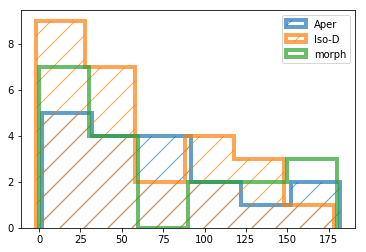

In [113]:
plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

In [ ]:
dA_a1 = datacube.get_centroid_result('diff_angle', 'APER', nums=nums1, fill_value=0)
dA_std_a1 = datacube.get_centroid_result('diff_angle_std', 'APER', nums=nums1, fill_value=99)
dA_d1 = datacube.get_centroid_result('diff_angle', 'ISO-D', nums=nums1, fill_value=0)
dA_std_d1 = datacube.get_centroid_result('diff_angle_std', 'ISO-D', nums=nums1, fill_value=99)
dA_dm1 = datacube.get_centroid_result('diff_angle', 'ISO-Dm', nums=nums1, fill_value=0)
dA_std_dm1 = datacube.get_centroid_result('diff_angle_std', 'ISO-Dm', nums=nums1, fill_value=99)